# Finetune EfficientNet-B5


## efficientnetb5_456repetitive


With 456x456 repetitive-padded melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnetb5_456repetitive'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b5(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-3, -2, -1]:  # Use negative indices to target the last 3 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_8920\3408896021.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=64,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=64,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.49it/s, Loss=0.2687091529369354, Elapsed=73.1206s, ETA=0.0000s]  


Epoch 1 completed in 525.2456s
Train Loss: 0.9033142373116765 - Train Accuracy: 62.92937744510526
Validation Loss: 0.7555213430583877 - Validation Accuracy: 68.85816800337695

Epoch 2/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.50it/s, Loss=0.06812527775764465, Elapsed=70.7367s, ETA=0.0000s] 


Epoch 2 completed in 521.3824s
Train Loss: 0.6552718848033166 - Train Accuracy: 73.22991338956605
Validation Loss: 0.6554344798494506 - Validation Accuracy: 72.67834529337273

Epoch 3/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.49it/s, Loss=0.0029865324031561613, Elapsed=70.9480s, ETA=0.0000s]


Epoch 3 completed in 521.3818s
Train Loss: 0.5360058575178538 - Train Accuracy: 78.16874335722846
Validation Loss: 0.642334429289358 - Validation Accuracy: 73.73364288729421

Epoch 4/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.49it/s, Loss=0.05484195426106453, Elapsed=70.8681s, ETA=0.0000s] 


Epoch 4 completed in 521.3768s
Train Loss: 0.44333874396494605 - Train Accuracy: 81.8932181542706
Validation Loss: 0.6941320549371659 - Validation Accuracy: 78.56690586745462

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.50it/s, Loss=0.018604280427098274, Elapsed=70.6419s, ETA=0.0000s]


Epoch 5 completed in 521.2662s
Train Loss: 0.361556033764234 - Train Accuracy: 85.00712331245336
Validation Loss: 0.609306076541543 - Validation Accuracy: 79.46390882228789

Epoch 6/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.49it/s, Loss=0.06743848323822021, Elapsed=70.7074s, ETA=0.0000s] 


Epoch 6 completed in 521.7015s
Train Loss: 0.28276287749215595 - Train Accuracy: 87.83609597250175
Validation Loss: 0.8414834210736639 - Validation Accuracy: 78.51414098775855

EarlyStopping counter: 1/5
Epoch 7/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.50it/s, Loss=0.00021495095279533416, Elapsed=70.5962s, ETA=0.0000s]


Epoch 7 completed in 521.6313s
Train Loss: 0.23111262684081466 - Train Accuracy: 89.76504375749079
Validation Loss: 0.8368039140279518 - Validation Accuracy: 78.49303503588013

EarlyStopping counter: 2/5
Epoch 8/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.50it/s, Loss=0.0017283695051446557, Elapsed=70.6870s, ETA=0.0000s]


Epoch 8 completed in 522.0493s
Train Loss: 0.18826294866661433 - Train Accuracy: 91.5447411863142
Validation Loss: 0.9948157637025349 - Validation Accuracy: 79.85436893203884

EarlyStopping counter: 3/5
Epoch 9/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.50it/s, Loss=0.042148809880018234, Elapsed=70.5997s, ETA=0.0000s]


Epoch 9 completed in 520.8468s
Train Loss: 0.14913296627282407 - Train Accuracy: 93.22493837769386
Validation Loss: 0.9393300928875504 - Validation Accuracy: 79.8227100042212

EarlyStopping counter: 4/5
Epoch 10/50


Validating: 100%|██████████| 149/149 [00:59<00:00,  2.49it/s, Loss=0.0030400340911000967, Elapsed=70.9189s, ETA=0.0000s]

Epoch 10 completed in 521.6744s
Train Loss: 0.12227554081813817 - Train Accuracy: 94.46869134574071
Validation Loss: 1.0437788254497011 - Validation Accuracy: 78.71464753060363

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


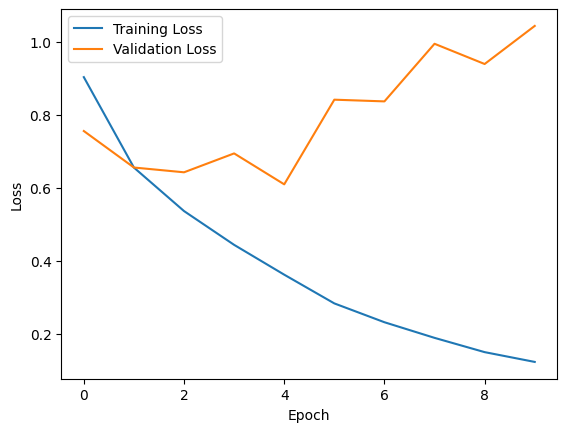

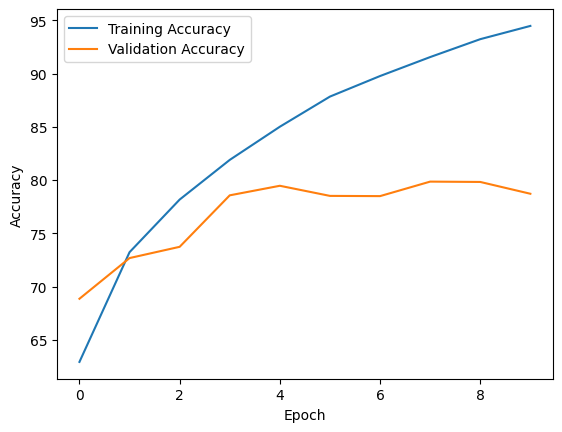

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 149/149 [01:11<00:00,  2.08it/s]


Test Accuracy: 0.7904
Test Precision: 0.7940
Test Recall: 0.7904
Test F1-score: 0.7905

              precision    recall  f1-score   support

       Anger       0.74      0.82      0.78       916
       Bored       0.83      0.93      0.87      1098
     Disgust       0.50      0.66      0.57       291
        Fear       0.54      0.55      0.55       308
       Happy       0.84      0.75      0.79      1914
     Neutral       0.77      0.76      0.76      2226
    Question       0.90      0.94      0.92      1139
         Sad       0.80      0.74      0.77       857
    Surprise       0.82      0.72      0.76       728

    accuracy                           0.79      9477
   macro avg       0.75      0.76      0.75      9477
weighted avg       0.79      0.79      0.79      9477



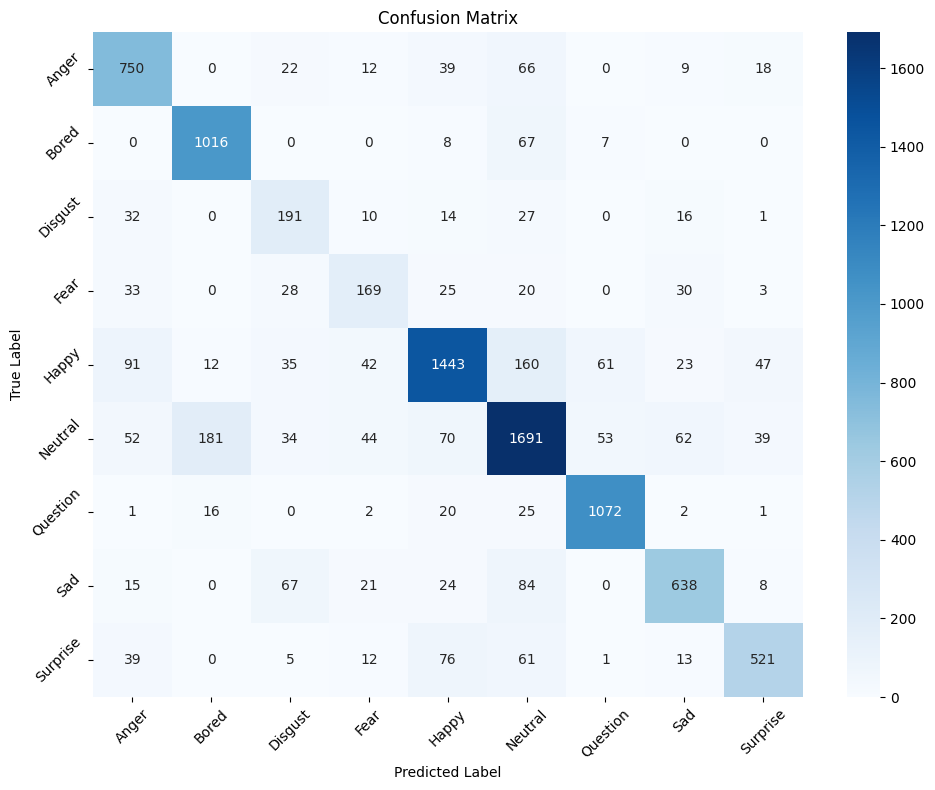

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)